# Deep Reinforcement Learning — Doom Agent (SS2025)

Welcome to the last assignment for the **Deep Reinforcement Learning** course (SS2025). In this notebook, you"ll implement and train a reinforcement learning agent to play **Doom**.

You will:
- Set up a custom VizDoom environment with shaped rewards
- Train an agent using an approach of your choice
- Track reward components across episodes
- Evaluate the best model
- Visualize performance with replays and GIFs
- Export the trained agent to ONNX to submit to the evaluation server

In [516]:
# Clone repo
#!git clone https://$token@github.com/gerkone/jku.wad.git
#%cd jku.wad

In [517]:
# Install the dependencies
#!pip install torch numpy matplotlib vizdoom portpicker gym onnx

In [518]:
from IPython import get_ipython
get_ipython().run_line_magic('load_ext', 'autoreload')
get_ipython().run_line_magic('autoreload', '2')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [519]:
from datetime import datetime
from collections import deque
from copy import deepcopy
import random
from torch import nn
from doom_arena import VizdoomMPEnv

In [520]:
from agents.utils import *
from agents.visualizations import *
from agents.helpers import *
from agents.dqn import EfficientDQN, epsilon_greedy, soft_update_target_network, LargeDQN, SmallDQN

In [521]:
rng = np.random.default_rng(100)

In [532]:
# Create folder for training
training_id = datetime.now().strftime("%Y%m%d_%H%M%S")
training_folder = os.path.join("runs", training_id)
os.makedirs(training_folder, exist_ok=True)
print("Using folder:", training_folder)

# Define loggers
logger = FileLogger(training_folder, also_print=True)
activation_logger = FileLogger(training_folder, filename="activations.txt", also_print=False)

Using folder: runs/20250621_213232


## Environment configuration

ViZDoom supports multiple visual buffers that can be used as input for training agents. Each buffer provides different information about the game environment, as seen from left to right:


Screen
- The default first-person RGB view seen by the agent.

Labels
- A semantic map where each pixel is tagged with an object ID (e.g., enemy, item, wall).

Depth
- A grayscale map showing the distance from the agent to surfaces in the scene.

Automap
- A top-down schematic view of the map, useful for global navigation tasks.

![buffers gif](https://vizdoom.farama.org/_images/vizdoom-demo.gif)

In [522]:
USE_GRAYSCALE = False  # ← flip to False for RGB

PLAYER_CONFIG = {
    # NOTE: "algo_type" defaults to POLICY in evaluation script!
    "algo_type": "QVALUE",  # OPTIONAL, change to POLICY if using policy-based (eg PPO)
    "n_stack_frames": 1, #4, # 1 # Temporal information
    "extra_state": ["labels"], #["labels"],#, "automap"], #["depth", "labels", "automap"],
    "hud": "none",
    "crosshair": True,
    "screen_format": 8 if USE_GRAYSCALE else 0,
}

In [523]:
# TODO: environment training paramters
N_STACK_FRAMES = 1 # 4 does not work yet!
NUM_PLAYERS = 2 #3
NUM_BOTS = 3 #1, #6
EPISODE_TIMEOUT = 2000
# TODO: model hyperparams
GAMMA = 0.95
EPISODES = 2 # 500
BATCH_SIZE = 64
REPLAY_BUFFER_SIZE = 20_000
LEARNING_RATE = 5e-5
EPSILON_START = 1.0
EPSILON_END = 0.1
EPSILON_DECAY = 0.995 # 0.987
N_EPOCHS =30
TARGET_UPDATE_FREQ = 1000
FRAME_SKIPPING = 0
FRAME_SKIPPING_STOP = 100
DEBUG = True
PRINT_EVERY = 20
VIDEO_DURING_TRAINING = True
EVALUATION_EVERY = 10

In [ ]:
def analyze_activations(result, prefix="", title="Value", logger: FileLogger = activation_logger, also_print: bool = False):
    activation_analyzed = f"{prefix}{'|' if prefix != "" else ""}{title:<15}| Shape: {list(result.shape)},\tMean: {result.mean().item():.2f},\tStd: {result.std().item():.2f},\tNorm: {torch.norm(result).item():.2f}"
    
    if logger is not None:
        logger.log(activation_analyzed, print_once=also_print)

In [ ]:
def analyze_activations(result, prefix="", title="Value", logger: FileLogger = activation_logger, also_print: bool = False):
    activation_analyzed = f"{prefix}{'|' if prefix != "" else ""}{title:<15}| Shape: {list(result.shape)},\tMean: {result.mean().item():.2f},\tStd: {result.std().item():.2f},\tNorm: {torch.norm(result).item():.2f}"
    
    if logger is not None:
        logger.log(activation_analyzed, print_once=also_print)

In [ ]:
rand_tensor = torch.rand(size=torch.stack(obs_test).shape).to(device).split(obs_states.get_dims(return_dict=False), dim=1)

with torch.no_grad():
    analyze_activations(rand_tensor[0], prefix=f'Episode 0', title="T1", also_print = DEBUG)
    analyze_activations(rand_tensor[1], prefix=f'Episode 0', title="T2", also_print = DEBUG)
    result_enc = model.encoders(rand_tensor)
    analyze_activations(result_enc, prefix=f'Episode 0', title="Encoder", also_print = DEBUG)
    result_head =model.head_first(result_enc)
    analyze_activations(result_head, prefix=f'Episode 0', title="Head", also_print = DEBUG)
    result_value_head = model.value_head(result_head)
    result_advantage_head = model.advantage_head(result_head)
    analyze_activations(result_value_head, prefix=f'Episode 0', title="Value", also_print = DEBUG)
    analyze_activations(result_advantage_head, prefix=f'Episode 0', title="Advantage", also_print = DEBUG)
    
    q_values = result_value_head + result_advantage_head - result_advantage_head.mean(dim=1, keepdim=True)
    analyze_activations(q_values, prefix=f'Episode 0', title="Q Vals", also_print = DEBUG)
    activation_logger.log(f"{'Q Vals List':<15}| {q_values.tolist()}", print_once= DEBUG)
    activation_logger.log(f"{'Actions':<15}| {q_values.argmax(dim=1).tolist()}", print_once = DEBUG)

T1             | Shape: [2, 3, 128, 128],	Mean: 0.50,	Std: 0.29,	Norm: 181.10
T2             | Shape: [2, 1, 128, 128],	Mean: 0.50,	Std: 0.29,	Norm: 104.42
Encoder        | Shape: [2, 256],	Mean: -0.00,	Std: 0.06,	Norm: 1.44
Head           | Shape: [2, 1024],	Mean: 0.02,	Std: 0.04,	Norm: 1.90
Value          | Shape: [2, 1],	Mean: 0.05,	Std: 0.00,	Norm: 0.07
Advantage      | Shape: [2, 8],	Mean: -0.01,	Std: 0.15,	Norm: 0.60
Q Vals|Value          | Shape: [2, 8],	Mean: 0.05,	Std: 0.15,	Norm: 0.63
Q Vals List    | [[0.22265030443668365, 0.014751700684428215, -0.15034343302249908, -0.03690129518508911, 0.1651739478111267, -0.17291323840618134, 0.2462504506111145, 0.09619126468896866], [0.22083276510238647, 0.013270579278469086, -0.1496608555316925, -0.03722869232296944, 0.17368829250335693, -0.1654372215270996, 0.23790210485458374, 0.0966392457485199]]
Actions        | [6, 6]


In [ ]:
rand_tensor = torch.rand(size=torch.stack(obs_test).shape).to(device).split(obs_states.get_dims(return_dict=False), dim=1)

with torch.no_grad():
    analyze_activations(rand_tensor[0], prefix=f'Episode 0', title="T1", also_print = DEBUG)
    analyze_activations(rand_tensor[1], prefix=f'Episode 0', title="T2", also_print = DEBUG)
    result_enc = model.encoders(rand_tensor)
    analyze_activations(result_enc, prefix=f'Episode 0', title="Encoder", also_print = DEBUG)
    result_head =model.head_first(result_enc)
    analyze_activations(result_head, prefix=f'Episode 0', title="Head", also_print = DEBUG)
    result_value_head = model.value_head(result_head)
    result_advantage_head = model.advantage_head(result_head)
    analyze_activations(result_value_head, prefix=f'Episode 0', title="Value", also_print = DEBUG)
    analyze_activations(result_advantage_head, prefix=f'Episode 0', title="Advantage", also_print = DEBUG)
    
    q_values = result_value_head + result_advantage_head - result_advantage_head.mean(dim=1, keepdim=True)
    analyze_activations(q_values, prefix=f'Episode 0', title="Q Vals", also_print = DEBUG)
    activation_logger.log(f"{'Q Vals List':<15}| {q_values.tolist()}", print_once= DEBUG)
    activation_logger.log(f"{'Actions':<15}| {q_values.argmax(dim=1).tolist()}", print_once = DEBUG)

T1             | Shape: [2, 3, 128, 128],	Mean: 0.50,	Std: 0.29,	Norm: 181.10
T2             | Shape: [2, 1, 128, 128],	Mean: 0.50,	Std: 0.29,	Norm: 104.42
Encoder        | Shape: [2, 256],	Mean: -0.00,	Std: 0.06,	Norm: 1.44
Head           | Shape: [2, 1024],	Mean: 0.02,	Std: 0.04,	Norm: 1.90
Value          | Shape: [2, 1],	Mean: 0.05,	Std: 0.00,	Norm: 0.07
Advantage      | Shape: [2, 8],	Mean: -0.01,	Std: 0.15,	Norm: 0.60
Q Vals|Value          | Shape: [2, 8],	Mean: 0.05,	Std: 0.15,	Norm: 0.63
Q Vals List    | [[0.22265030443668365, 0.014751700684428215, -0.15034343302249908, -0.03690129518508911, 0.1651739478111267, -0.17291323840618134, 0.2462504506111145, 0.09619126468896866], [0.22083276510238647, 0.013270579278469086, -0.1496608555316925, -0.03722869232296944, 0.17368829250335693, -0.1654372215270996, 0.23790210485458374, 0.0966392457485199]]
Actions        | [6, 6]


In [524]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print("Device:", device)

DTYPE = torch.float32

obs_states = ExtraStates(PLAYER_CONFIG["extra_state"] + ["screen"], num_frames = N_STACK_FRAMES)

reward_fn = YourReward(num_players=NUM_PLAYERS)

def build_env():
    env = VizdoomMPEnv(
        num_players=NUM_PLAYERS, # 4 is max
        num_bots=NUM_BOTS,
        bot_skill=1, # Increased difficulty
        doom_map="TRNM",  # ROOM = NOTE simple, small map; other options: TRNM, TRNMBIG
        extra_state=PLAYER_CONFIG["extra_state"],  # see info about states at the beginning of "Environment configuration" above
        episode_timeout=EPISODE_TIMEOUT,
        n_stack_frames=PLAYER_CONFIG["n_stack_frames"],
        crosshair=PLAYER_CONFIG["crosshair"],
        hud=PLAYER_CONFIG["hud"],
        screen_format=PLAYER_CONFIG["screen_format"],
        reward_fn=reward_fn,
        seed = rng.integers(1, 2000, NUM_PLAYERS),
        ticrate = 35*3,
    )
    return env

env = build_env()
with suppress_output(): # Reset to get player and game information
    _ = env.reset()

Device: mps
Environment Seed: [1534 1670]
Host 54458
Player 54458




## Agent

Implement **your own agent** in the code cell that follows.

* In `agents/dqn.py` and `agents/ppo.py` you’ll find very small **skeletons**—they compile but are meant only as reference or quick tests.  
  Feel free to open them, borrow ideas, extend them, or ignore them entirely.
* The notebook does **not** import those files automatically; whatever class you define in the next cell is the one that will be trained.
* You may keep the DQN interface, switch to PPO, or try something else.
* Tweak any hyper-parameters (`PLAYER_CONFIG`, ε-schedule, optimiser, etc.) and document what you tried.


In [525]:
# ================================================================
# Initialise your networks and training utilities
# ================================================================
env_actions = EnvActions(env, rng=rng)

# main Q-network
model = EfficientDQN(
    input_dim = 0,
    action_space=env_actions.action_space,
    obs_state_infos=obs_states,
).to(device, dtype=DTYPE)

# Load a model from file
#model = model.load_model("runs/20250621_182219/best_model_20250621_182229.pt").to(device, dtype=DTYPE)

Initialized model with 1222121 parameters!


In [526]:
target_model  = deepcopy(model).to(device, dtype=DTYPE)
optimizer  = torch.optim.AdamW(target_model.parameters(), lr=LEARNING_RATE, weight_decay=5e-4)
scheduler  = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=20, eta_min=1e-8)
loss_fn = nn.MSELoss()
replay_buffer = deque(maxlen=REPLAY_BUFFER_SIZE)

## Example of environment

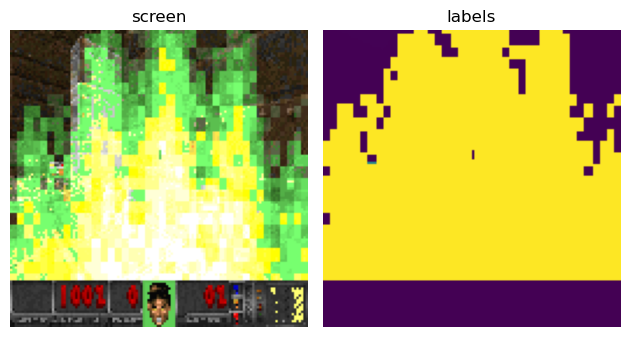

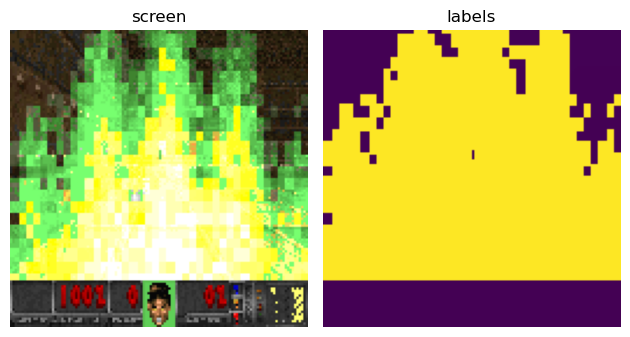

In [527]:
# Reset environment
with suppress_output():
    obs_test: list = env.reset()
    
for player in range(len(obs_test)):
    plot_images(obs_test[player], obs_states.get_dims())

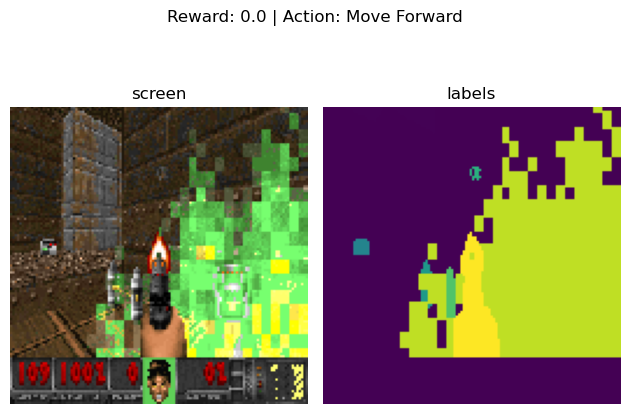

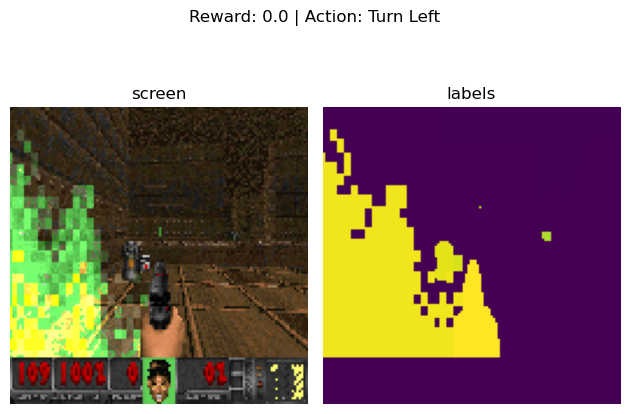

In [528]:
# Iterate 60 steps
STEPS = 30

for i in range(STEPS):
    actions = env_actions.get_random_action(NUM_PLAYERS)
    #actions = env_actions.get_action_value(1, NUM_PLAYERS)
    #actions = epsilon_greedy(env, model, obs_test, 0.5, env_actions, device, DTYPE, debug=True) # 50% random actions by model
    #actions = epsilon_greedy(env, model, torch.rand_like(torch.stack(obs_test)), 0, env_actions, device, DTYPE, debug=False) # model fully random
    obs_test, reward = env.step(actions)[0:2]

for player in range(env.num_players):
    action_print = [actions] if isinstance(actions, int) else actions
    plot_images(obs_test[player], obs_states.get_dims(), **{"title": f"Reward: {reward[player]:.1f} | Action: {env_actions.get_action_name(action_print[player])}"})


In [634]:
def analyze_activations(result, prefix="", title="Value", logger: FileLogger = activation_logger, also_print: bool = False):
    activation_analyzed = f"{prefix}{'|' if prefix != "" else ""}{title:<15}| Shape: {list(result.shape)},\tMean: {result.mean().item():.2f},\tStd: {result.std().item():.2f},\tNorm: {torch.norm(result).item():.2f}"
    
    if logger is not None:
        logger.log(activation_analyzed, print_once=also_print)

In [ ]:
rand_tensor = torch.rand(size=torch.stack(obs_test).shape).to(device).split(obs_states.get_dims(return_dict=False), dim=1)

with torch.no_grad():
    analyze_activations(rand_tensor[0], prefix=f'Episode 0', title="T1", also_print = DEBUG)
    analyze_activations(rand_tensor[1], prefix=f'Episode 0', title="T2", also_print = DEBUG)
    result_enc = model.encoders(rand_tensor)
    analyze_activations(result_enc, prefix=f'Episode 0', title="Encoder", also_print = DEBUG)
    result_head =model.head_first(result_enc)
    analyze_activations(result_head, prefix=f'Episode 0', title="Head", also_print = DEBUG)
    result_value_head = model.value_head(result_head)
    result_advantage_head = model.advantage_head(result_head)
    analyze_activations(result_value_head, prefix=f'Episode 0', title="Value", also_print = DEBUG)
    analyze_activations(result_advantage_head, prefix=f'Episode 0', title="Advantage", also_print = DEBUG)
    
    q_values = result_value_head + result_advantage_head - result_advantage_head.mean(dim=1, keepdim=True)
    analyze_activations(q_values, prefix=f'Episode 0', title="Q Vals", also_print = DEBUG)
    activation_logger.log(f"{'Q Vals List':<15}| {q_values.tolist()}", print_once= DEBUG)
    activation_logger.log(f"{'Actions':<15}| {q_values.argmax(dim=1).tolist()}", print_once = DEBUG)

T1             | Shape: [2, 3, 128, 128],	Mean: 0.50,	Std: 0.29,	Norm: 181.10
T2             | Shape: [2, 1, 128, 128],	Mean: 0.50,	Std: 0.29,	Norm: 104.42
Encoder        | Shape: [2, 256],	Mean: -0.00,	Std: 0.06,	Norm: 1.44
Head           | Shape: [2, 1024],	Mean: 0.02,	Std: 0.04,	Norm: 1.90
Value          | Shape: [2, 1],	Mean: 0.05,	Std: 0.00,	Norm: 0.07
Advantage      | Shape: [2, 8],	Mean: -0.01,	Std: 0.15,	Norm: 0.60
Q Vals|Value          | Shape: [2, 8],	Mean: 0.05,	Std: 0.15,	Norm: 0.63
Q Vals List    | [[0.22265030443668365, 0.014751700684428215, -0.15034343302249908, -0.03690129518508911, 0.1651739478111267, -0.17291323840618134, 0.2462504506111145, 0.09619126468896866], [0.22083276510238647, 0.013270579278469086, -0.1496608555316925, -0.03722869232296944, 0.17368829250335693, -0.1654372215270996, 0.23790210485458374, 0.0966392457485199]]
Actions        | [6, 6]


### Example of Reward

In [529]:
player_idx = rng.integers(env.num_players)

player_game_vars = env.envs[player_idx].unwrapped._game_vars
player_game_vars_pre = env.envs[player_idx].unwrapped._game_vars_pre
reward = reward_fn(0, player_game_vars, player_game_vars_pre, 0)
print(f"Reward: {np.sum(reward)} | {reward}")
for key, value_now, value_old in zip(player_game_vars, player_game_vars.values(), player_game_vars_pre.values()):   
    print(f"{key+':':<25}{value_now:.0f} | {value_old:.0f}")

Reward: 0.020730095800526552 | (0.0, 0.0, -0.0, 0.021730095800526553, 0.0, -0.001, 0.0)
HEALTH:                  100 | 100
AMMO3:                   0 | 0
FRAGCOUNT:               0 | 0
ARMOR:                   0 | 0
HITCOUNT:                0 | 0
HITS_TAKEN:              0 | 0
DEAD:                    0 | 0
DEATHCOUNT:              0 | 0
DAMAGECOUNT:             0 | 0
DAMAGE_TAKEN:            0 | 0
KILLCOUNT:               0 | 0
SELECTED_WEAPON:         2 | 2
SELECTED_WEAPON_AMMO:    109 | 109
POSITION_X:              230 | 231
POSITION_Y:              1460 | 1461


## Training loop

Training:   0%|          | 0/100 [00:00<?, ? episode/s]

19:23:28 | Episode: 0 | Steps done: 0 | Gathering rollout (currently 0)
19:23:46 | Episode: 0 | Training for 30 epochs
19:23:47 | Episode: 0 | Updating target network...
19:23:47 | Episode: 0 | Rewards:
	Reward: [18. 13.] | Avg Reward: 16.0 | Loss: 0.0788 | ε: 0.995 | LR: 4.97e-05
	Metrics - ['frags: 0', 'hits: 4', 'damage_taken: 0', 'movement: 9', 'ammo_efficiency: 4', 'survival: -1', 'health_pickup: 0']
	Actions - 0: 178, 1: 598, 2: 809, 3: 442, 4: 447, 5: 587, 6: 588, 7: 351
19:23:47 | Episode: 0 | Replaying animation...
19:24:27 | Episode: 0 | Running quick evaluation...
Successfully stored the model: runs/20250621_192327/best_model_20250621_192451.pt
19:24:53 | Episode: 1 | Steps done: 2000 | Gathering rollout (currently 4000)
19:25:11 | Episode: 1 | Training for 30 epochs
19:25:12 | Episode: 1 | Updating target network...
19:25:12 | Episode: 1 | Rewards:
	Reward: [16. 16.] | Avg Reward: 16.0 | Loss: 0.0569 | ε: 0.990 | LR: 4.88e-05
	Metrics - ['frags: 0', 'hits: 2', 'damage_taken

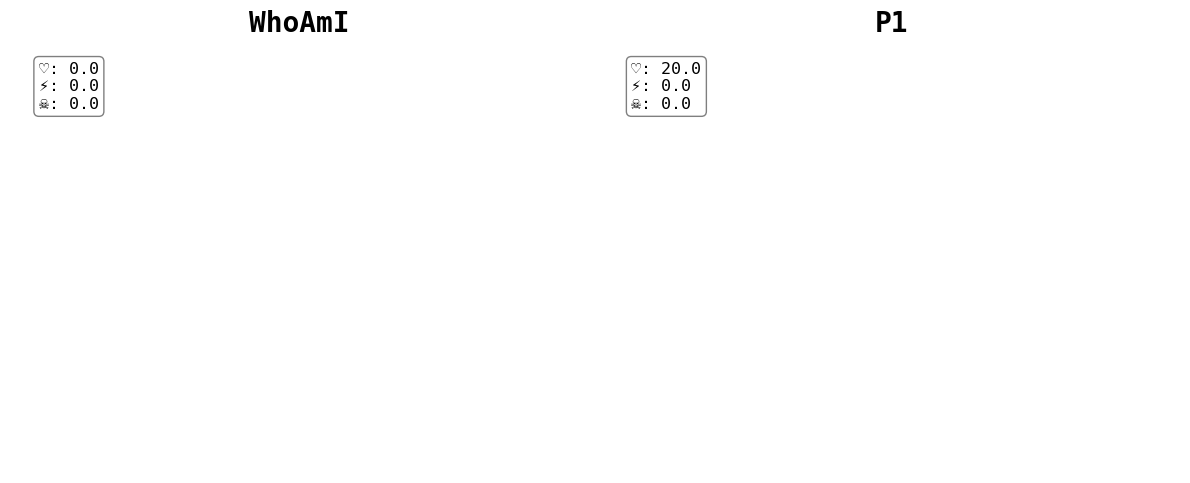

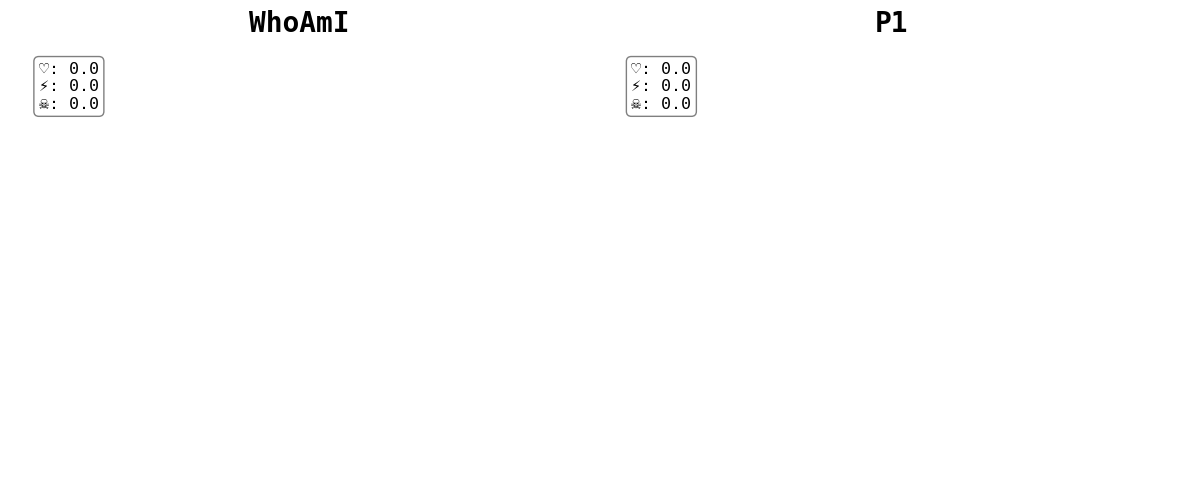

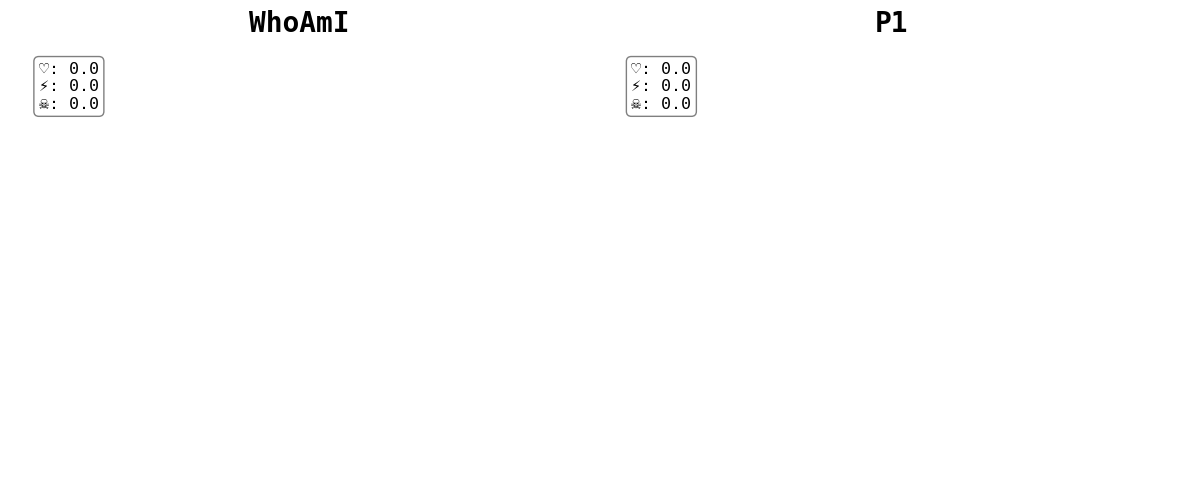

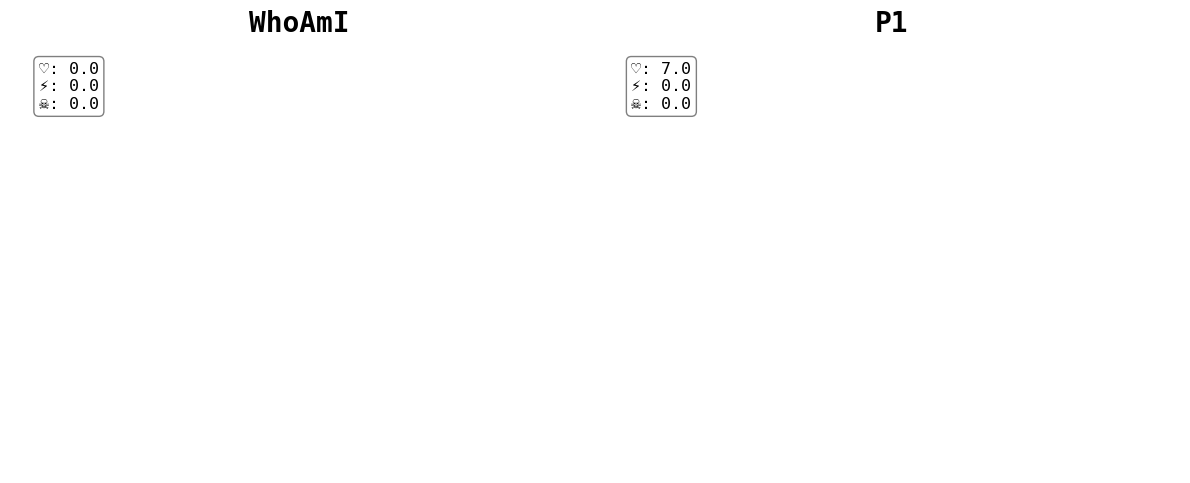

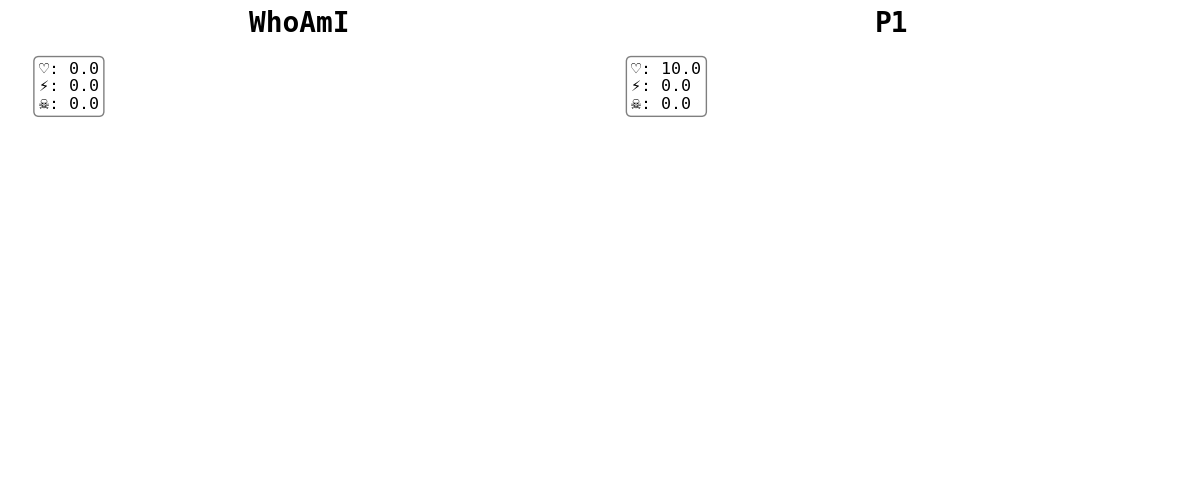

In [ ]:
# ---------------------  TRAINING LOOP  ----------------------

# Training settings
q_loss_list, epsilon_history = [], []
reward_history = {player: [] for player in range(env.num_players)}
best_reward = float("-inf")
best_model = None

epsilon = EPSILON_START 
steps_done = 0


with TqdmProgress(total=EPISODES) as progress_bar:
    for episode in progress_bar:
        
        episode_action_counter = ActionCounter()
        progress_bar.set_description(episode)
        
        with suppress_output():
            #obs = torch.stack([env.reset() for env in environments.values()])
            obs: torch.Tensor = env.reset()
        
        # Episode variables for each player
        episode_metrics = {player: {"frags": 0, "hits": 0, "damage_taken": 0, "movement": 0, "ammo_efficiency": 0, "survival": 0, "health_pickup": 0} for player in range(env.num_players)}
        episode_reward = {player: 0.0 for player in range(env.num_players)}

        done = False
        model.eval()
        
        episode_msg = f"{datetime.now().strftime("%H:%M:%S")} | Episode: {episode} | Steps done: {steps_done} | Gathering rollout (currently {len(replay_buffer)})"
        logger.log(episode_msg)
        
        # ───────── rollout ─────────────────────────────────────────────
        while not done:
            
            # Skip Frames (Testing - I am aware that in the original paper they stacked the images. I want to get many more steps at the beginning)
            act = epsilon_greedy(env, model, obs, epsilon, env_actions, device, DTYPE, episode_action_counter)
            
            max_skip_steps = max(FRAME_SKIPPING * (episode < FRAME_SKIPPING_STOP), 1)
            for skip_steps in range(max_skip_steps):
                next_obs, reward, done, _ = env.step(act)            
                steps_done += 1

            # ----- reward definition ----------------
            for player_idx in range(env.num_players):
                episode_reward[player_idx] += np.sum(reward[player_idx]) # Should be a list with one value
                reward_components = reward_fn(None, env.envs[player_idx].unwrapped._game_vars, env.envs[player_idx].unwrapped._game_vars_pre, None)

                if len(reward_components) >= 6:
                    episode_metrics[player_idx]["frags"] += reward_components[0]
                    episode_metrics[player_idx]["hits"] += reward_components[1]
                    episode_metrics[player_idx]["damage_taken"] += reward_components[2]
                    episode_metrics[player_idx]["movement"] += reward_components[3]
                    episode_metrics[player_idx]["ammo_efficiency"] += reward_components[4]
                    episode_metrics[player_idx]["survival"] += reward_components[5]
                    episode_metrics[player_idx]["health_pickup"] += reward_components[6]
            
                # ----- buffer and environment handling ----------------
                if env.num_players == 1:
                    act = [act]
                    
                replay_buffer.append((obs[player_idx], act[player_idx], reward[player_idx], next_obs[player_idx], done))


        obs = next_obs
        [reward_history[player_idx].append(reward) for player_idx, reward in episode_reward.items()] # Append rewards for every player
        epsilon_history.append(epsilon)

        # ───────── learning step (experience replay) ──────────────────
        if len(replay_buffer) >= BATCH_SIZE:

            model.train()
            train_msg = f"{datetime.now().strftime("%H:%M:%S")} | Episode: {episode} | Training for {N_EPOCHS} epochs"
            logger.log(train_msg)
            
            for epoch in range(N_EPOCHS):

                batch = random.sample(replay_buffer, BATCH_SIZE)
                states, actions, rewards, next_states, dones = zip(*batch)

                # Convert to tensors for training
                states = torch.stack(states).to(device, DTYPE)
                next_states = torch.stack(next_states).to(device, DTYPE)
                actions = torch.tensor(actions, device=device)
                rewards = torch.tensor(rewards, device=device, dtype=torch.float32) #.squeeze(1) # Added squeeze here
                dones = torch.tensor(dones, device=device, dtype=torch.float32)

                current_q = model(states).gather(1, actions.unsqueeze(1)).squeeze(1)
                
                # Target q values
                with torch.no_grad():
                    next_q = target_model(next_states).max(1)[0] #.values
                    target_q = rewards + GAMMA * next_q * (1 - dones)
                
                loss = loss_fn(current_q, target_q) # TODO: Check whether correct, did that in Deep Q Assignment

                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                
                q_loss_list.append(loss.item())
            
            # Update scheduler and epsilon
            scheduler.step()
            epsilon = max(EPSILON_END, epsilon * EPSILON_DECAY)
            
            progress_bar.update_step_count()

            # Update target network        
            target_update_msg = f"{datetime.now().strftime("%H:%M:%S")} | Episode: {episode} | Updating target network..."
            logger.log(target_update_msg)
            soft_update_target_network(model, target_model, tau=1e-3)
            #hard_update_target_network(target_model, model)
            
        else:
            train_fail_msg = f"{datetime.now().strftime("%H:%M:%S")} | Episode: {episode} | Replay buffer smaller than batchsize {len(replay_buffer)} {BATCH_SIZE}"
            logger.log(train_fail_msg, print_once=True)

        # -------- logging ----------
        avg_reward = get_avg_reward(reward_history, episodes=PRINT_EVERY, round=0)
        avg_loss = np.mean(q_loss_list[-10:]) if q_loss_list else 0
        stacked_episode_reward = np.array([np.round(reward, 0) for reward in episode_reward.values()])
        
        action_counts = episode_action_counter.get_counts()

        # Rewards and losses
        reward_msg = f"{datetime.now().strftime("%H:%M:%S")} | Episode: {episode} | Rewards:\n"
        reward_msg += f"\tReward: {stacked_episode_reward} | Avg Reward: {avg_reward} | Loss: {avg_loss:.4f} | ε: {epsilon:.3f} | LR: {scheduler.get_last_lr()[0]:.2e}"
        reward_msg += f"\n\tMetrics - {[f'{metric}: {value}' for metric, value in get_average_result(episode_metrics).items()]}"
        reward_msg += f"\n\tActions - {', '.join([f"{k}: {v}" for k, v in sorted(action_counts.items())])}"
        
        logger.log(reward_msg, print_once = episode % PRINT_EVERY == 0)
        
        
        progress_bar.set_postfix({
            "Avg Reward": f"{avg_reward}",
            "Loss": f"{avg_loss:.4f}",
            "Epsilon": f"{epsilon:.2f}"
        })
            
        # Show the video 
        if VIDEO_DURING_TRAINING and episode % PRINT_EVERY == 0:
            replay_msg = f"{datetime.now().strftime("%H:%M:%S")} | Episode: {episode} | Replaying animation..."
            logger.log(replay_msg)
            with suppress_output():
                replay_episode(env, target_model, device, DTYPE, path=training_folder, store=True, random_player=False)
        
        # ───────── quick evaluation for best-model tracking ───────────
        quick_eval_msg = f"{datetime.now().strftime("%H:%M:%S")} | Episode: {episode} | Running quick evaluation..."
        logger.log(quick_eval_msg)

        with suppress_output():
            eval_obs = env.reset(rng.integers(1000)) # List of obs
            
        eval_episode_rewards = [0.0] * env.num_players
        eval_done = False
        model.eval()
    
        while not eval_done:
            eval_action_list = epsilon_greedy(env, model, eval_obs, 0, env_actions, device, dtype=DTYPE)
            eval_next_obs_list, eval_reward_list, eval_done, _ = env.step(eval_action_list)
            for i in range(env.num_players):
                eval_episode_rewards[i] += eval_reward_list[i]
            eval_obs = eval_next_obs_list
        
        mean_eval_reward = np.mean(eval_episode_rewards)
        
        if mean_eval_reward > best_reward:
            best_reward = mean_eval_reward
            model_name = "best_model_" + datetime.now().strftime("%Y%m%d_%H%M%S") + ".pt"
            model.save_model(path=training_folder, filename=model_name)
            best_model = deepcopy(model)

In [ ]:
env.reset(seed=rng.integers(1000)) 

TypeError: ParallelEnv.reset() got an unexpected keyword argument 'seed'

## Dump to ONNX

In [ ]:
import onnx
import json

def onnx_dump(env, model, config, filename: str):
    # dummy state
    init_state = env.reset()[0].unsqueeze(0)

    # Export to ONNX
    torch.onnx.export(
        model.cpu(),
        args=init_state,
        f=filename,
        export_params=True,
        opset_version=11,
        do_constant_folding=True,
        input_names=["input"],
        output_names=["output"],
        dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}},
    )
    onnx_model = onnx.load(filename)

    meta = onnx_model.metadata_props.add()
    meta.key = "config"
    meta.value = json.dumps(config)

    onnx.save(onnx_model, filename)

    
# ---------------------  SAVE / EXPORT ---------------------------------------
final_model = best_model if best_model is not None else model  # choose best

onnx_filename = os.path.join(training_folder, "enhanced_doom_agent_onnx")
onnx_dump(env, final_model, PLAYER_CONFIG, onnx_filename)
print(f"Best network exported to {onnx_filename}")

Network game synchronization timeout: 60s.Network game synchronization timeout: 60s.
Waiting for players: 
Got connect from node 1.                
Waiting for players: .. [ 2/ 2]
Sending all here.                       

Total players: 2                        

Waiting for other players: .. [ 2/ 2]
Console player number: 1                
Received All Here, sending ACK.         
Console player number: 1                
Received All Here, sending ACK.         

Go                                      
Total players: 2                        

Console player number: 1                
Received All Here, sending ACK.         
Received "Go."                          

Total players: 2                        

Found WhoAmI (node 1, player 1)         
Found P1 (node 1, player 2)             
Found P1 (node 0, player 2)             


Best network exported to runs/20250621_192327/enhanced_doom_agent_onnx


### Evaluation and Visualization

In this final section, you can evaluate your trained agent, inspect its performance visually, and analyze reward components over time.


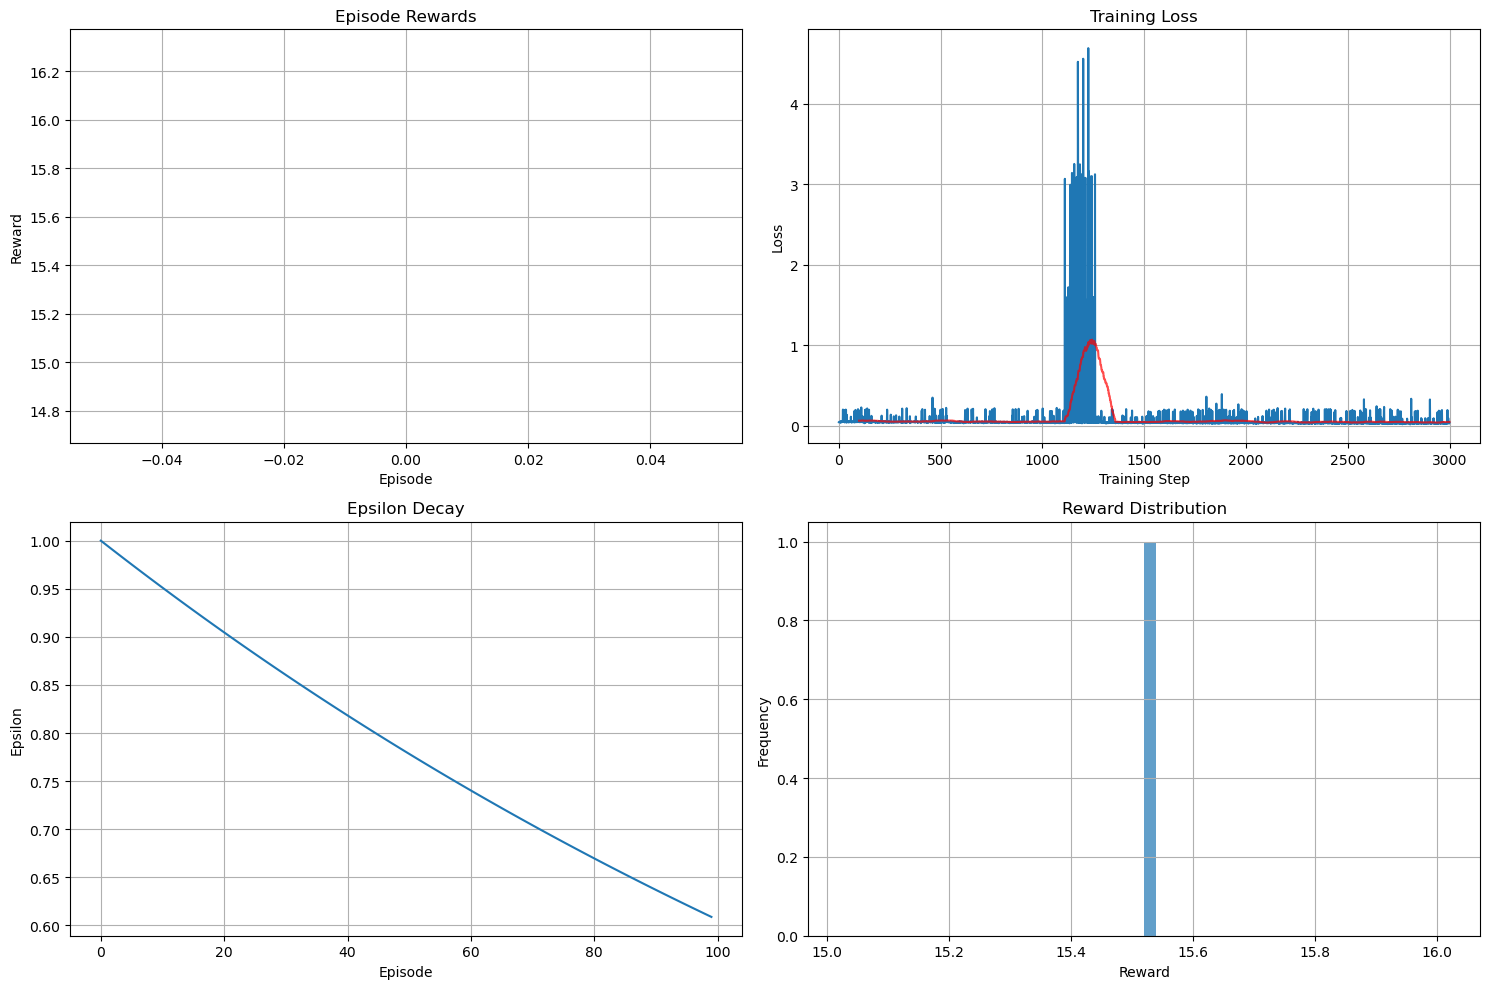

In [ ]:
plot_training_metrics(get_avg_reward(reward_history, episodes=0), q_loss_list, epsilon_history)

Enabling replays!


Final evaluation - Total reward: -33.0
Disabling replays!
Animation saved to 2025-06-21_20-56-53_-33.mp4


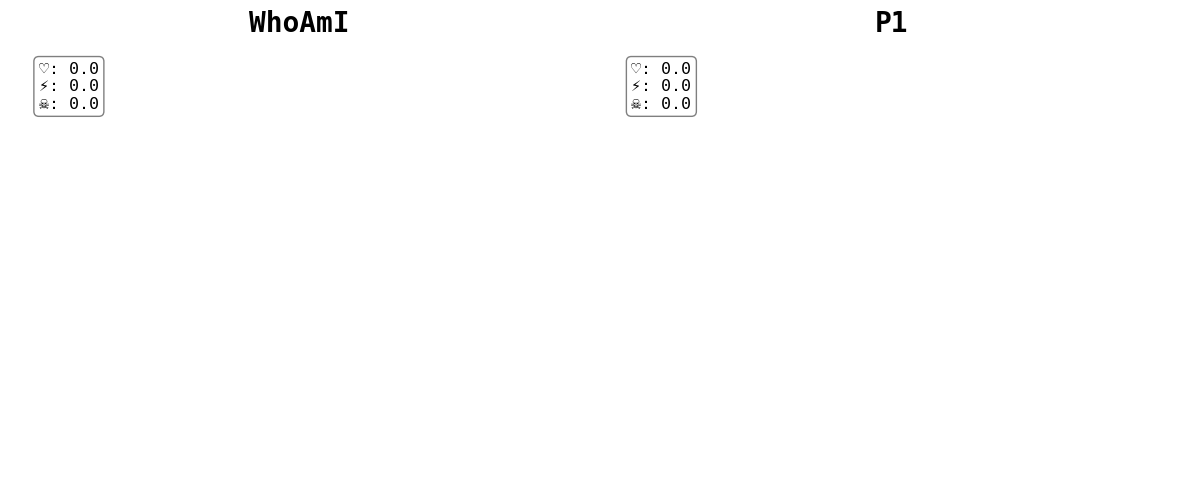

In [ ]:
replay_episode(env, final_model.cpu(), device, DTYPE, store=True, random_player=False)